# Story Telling

Gliomas are the most common primary brain tumors and are classified into Lower-Grade Glioma (LGG) and Glioblastoma Multiforme (GBM) based on histological and imaging criteria. While clinical characteristics contribute to diagnosis, molecular mutation profiling has become essential for accurate glioma grading. However, performing extensive molecular testing is expensive and resource-intensive, making it challenging for many healthcare settings to carry out comprehensive panels.

This project uses a dataset containing 20 frequently mutated genes and 3 key clinical features from the TCGA-LGG and TCGA-GBM cohorts.A major challenge is identifying the minimal yet most informative subset of mutation genes and clinical variables that can produce accurate predictions while reducing diagnostic cost and complexity.


# Problem Statement

The problem is to predict whether a patient has LGG or GBM and to find a small, optimal set of features that keeps accuracy high while reducing testing cost.

# Objectives

- Build a model to classify patients as LGG or GBM.

- Identify the most important genes and clinical features needed for accurate prediction.

- Reduce the number of molecular tests to lower diagnostic cost.

- Improve model performance using an optimal feature subset.

# I. Data import

 ### 1. Loading the required libraries

In [1]:
#----------------------1. Loading all the libs-----------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold ,GridSearchCV

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### 2. Loading the CSV file - Loading Dataset

In [3]:
# -----2. Read the CSV file -----------
# Ensure the filename matches your downloaded file
try:
    df = pd.read_csv('TCGA_InfoWithGrade.csv')
except FileNotFoundError:
    print("Error: Dataset not found. Check the file path.")
    # Exit or handle the error appropriately for your project
    exit()


# II. Exploratory Data Analysis (EDA)

## 1. Data Checking and Understanding 

### a. Checking the shape of the dataset

In [4]:
# -------1. Data shape- Quick Overview of Data---------
print("--- Data Shape ---")

# Number of rows and columns
print("Shape of the dataset:", df.shape)

# Quick overview of rows and columns
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

--- Data Shape ---
Shape of the dataset: (839, 24)
Number of rows: 839
Number of columns: 24


### b. Checking the first 5 rows of the dataset to get a picture of the data values

In [5]:
# ---------2. Printing 5 rows of the Dataset---------
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   Grade  Gender  Age_at_diagnosis  Race  IDH1  TP53  ATRX  PTEN  EGFR  CIC  \
0      0       0             51.30     0     1     0     0     0     0    0   
1      0       0             38.72     0     1     0     0     0     0    1   
2      0       0             35.17     0     1     1     1     0     0    0   
3      0       1             32.78     0     1     1     1     0     0    0   
4      0       0             31.51     0     1     1     1     0     0    0   

   ...  FUBP1  RB1  NOTCH1  BCOR  CSMD3  SMARCA4  GRIN2A  IDH2  FAT4  PDGFRA  
0  ...      1    0       0     0      0        0       0     0     0       0  
1  ...      0    0       0     0      0        0       0     0     0       0  
2  ...      0    0       0     0      0        0       0     0     0       0  
3  ...      0    0       0     0      0        0       0     0     1       0  
4  ...      0    0       0     0      0        0       0     0     0       0  

[5 rows x 24 columns]


### c. Renaming the target column for clarity and mapping 

In [6]:
# --- 3. DATA PREPARATION ---
# Rename the target column for clarity and map target values
df.rename(columns={'Grade': 'Tumor_Grade'}, inplace=True)
df['Tumor_Grade'] = df['Tumor_Grade'].map({0: 'LGG (Lower Grade)', 1: 'GBM (Glioblastoma)'})

# --- DEFINE X and y ---
X = df.drop('Tumor_Grade', axis=1)
y = df['Tumor_Grade']

# Define feature groups
CLINICAL_FEATURES = ['Gender', 'Age_at_diagnosis', 'Race']
MUTATION_FEATURES = [col for col in X.columns if col not in CLINICAL_FEATURES]

# Standardize the continuous feature 'Age_at_diagnosis'
scaler = StandardScaler()
X['Age_at_diagnosis'] = scaler.fit_transform(X[['Age_at_diagnosis']])

###  d. Checking the data types of all the columns in the dataset

In [7]:
# --- 4. Data Types (using .info())  ---
print("--- Column Data Types and Non-Null Counts ---")
# The .info() method provides a summary of all columns: dtype, non-null count, and memory usage.
df.info()

--- Column Data Types and Non-Null Counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Tumor_Grade       839 non-null    object 
 1   Gender            839 non-null    int64  
 2   Age_at_diagnosis  839 non-null    float64
 3   Race              839 non-null    int64  
 4   IDH1              839 non-null    int64  
 5   TP53              839 non-null    int64  
 6   ATRX              839 non-null    int64  
 7   PTEN              839 non-null    int64  
 8   EGFR              839 non-null    int64  
 9   CIC               839 non-null    int64  
 10  MUC16             839 non-null    int64  
 11  PIK3CA            839 non-null    int64  
 12  NF1               839 non-null    int64  
 13  PIK3R1            839 non-null    int64  
 14  FUBP1             839 non-null    int64  
 15  RB1               839 non-null    int64  
 16

###  e. Checking the Null values in all the columns in the dataset

In [8]:
#--- 5. Check for missing values/ Null Values---
print(df.isna().sum())
# The .isna()) method returns a boolean DataFrame, and .sum() counts the True (Null) values for each column.
null_counts = df.isna().sum()

# If the output is empty, it means there are no null values.
if null_counts.sum() == 0:
    print("NO NULL VALUES FOUND. The dataset is clean.")  


Tumor_Grade         0
Gender              0
Age_at_diagnosis    0
Race                0
IDH1                0
TP53                0
ATRX                0
PTEN                0
EGFR                0
CIC                 0
MUC16               0
PIK3CA              0
NF1                 0
PIK3R1              0
FUBP1               0
RB1                 0
NOTCH1              0
BCOR                0
CSMD3               0
SMARCA4             0
GRIN2A              0
IDH2                0
FAT4                0
PDGFRA              0
dtype: int64
NO NULL VALUES FOUND. The dataset is clean.


###  f. Descriptive Statistics for Age (Continuous Varibale)

In [9]:
# --- 6. Print the Statistical DIstribution  ---
print("\n--- Summary Statistics for Age ---")
print(df['Age_at_diagnosis'].describe())


--- Summary Statistics for Age ---
count    839.000000
mean      50.935411
std       15.702339
min       14.420000
25%       38.055000
50%       51.550000
75%       62.800000
max       89.290000
Name: Age_at_diagnosis, dtype: float64


##### Observations so far:
1) There are 839 rows and 23 columns in the dataset
2) Age column is the continous variable columns and rest all columns are categorical columns
3) There is no null value in any columns. 
There are 23 features in the dataset for the glioma brain tumor grading.
23 Fetaures are divided into two parts - 20 mutation features and 3 clinical features.

## 2. Clinical Features Analysis

###  a. Plot 1. Target Variable Analysis -Tumor Grade( LGG & GBM) VS Patients Count 

#### This is a standard count plot that visualizes the absolute number of patients in the cohort belonging to each primary tumor grade: LGG (Lower Grade) and GBM (Glioblastoma). 

In [10]:
def Target_Variable_Analysis():
    CUSTOM_COLORS = ['#C06C84', '#F67280']
    plt.subplot2grid((2, 4), (0, 0), colspan=2)
    ax = sns.countplot(x='Tumor_Grade', data=df, hue='Tumor_Grade', palette= CUSTOM_COLORS)
    plt.title('Distribution of Glioma Tumor Grade', fontsize=14, fontfamily='Poppins')
    plt.xlabel('Tumor Grade',fontsize=11)
    plt.ylabel('Count',fontsize=11)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

Observation:
The plot clearly shows that Lower Grade Gliomas are the majority class in this dataset(Refer Dashboard).

- LGG (Lower Grade): The highest count, totaling 487 patients.

- GBM (Glioblastoma): The lower count, totaling 352 patients.

- Total Cohort Size: 487 + 352 = 839 patients.

- Class Imbalance: LGG makes up approximately 58% of the cohort, while GBM makes up approximately 42%.

This finding is crucial as it contradicts the prevalence rates typically observed in the general population (where GBM is usually more common than LGG)

###  b. Plot 2. Age Distribution of Target Variable - Tumor Grade(LGG & GBM)

#### This plot compares the distribution of patient Age at Diagnosis across the two primary tumor grades: LGG (Lower Grade) and GBM (Glioblastoma). It is a stacked histogram with overlaid Kernel Density Estimates (KDEs) for clarity. The height of each bar represents the total number of patients within a 2-3 year age bin.

In [11]:
def Age_Distribution_by_grade():
    CUSTOM_COLORS = ['#C06C84', '#F67280']
    plt.subplot2grid((2, 4), (0, 2), colspan=2)
    sns.histplot(data=df, x='Age_at_diagnosis', hue='Tumor_Grade', kde=True, bins=25,palette=CUSTOM_COLORS, multiple="stack")
    plt.title('Age Distribution by Glioma Tumor Grade', fontsize=14, fontfamily='Poppins')
    plt.xlabel('Age at Diagnosis (Years)',fontsize=11)
    plt.ylabel('Count',fontsize=11)
    plt.legend(title='Grade', labels=['GBM (1)', 'LGG (0)'],fontsize=11)


Observations :(Refer Dashboard)

- The plot shows two highly distinct, grade-specific distributions, confirming that age is a powerful differentiator between the tumor types.

- Lower Grade Gliomas (LGG) predominantly affect younger patients, with the distribution peaking sharply in the 35–45 year age range.

- Glioblastoma (GBM) predominantly affects older patients, with the distribution centering around 60–70 years.

- A crossover point exists near 60 years, where the probability of a GBM diagnosis surpasses that of an LGG diagnosis,  making age 60 a critical clinical threshold.

### c. Plot 3. Gender Distribution of Target Variable  - Tumor Grade(LGG & GBM)

#### Two pie charts are displayed , each representing the percentage distribution of Male and Female patients specifically within the two defined tumor grades: LGG (Lower Grade) and GBM (Glioblastoma).

In [12]:
def plot_gender_distribution(df, fig, axes):
    CUSTOM_COLORS = ['#C06C84', '#F67280']
    gender_labels = {0: 'Male', 1: 'Female'}
    # --- 3. Gender Distribution by Tumor Grade (LGG vs. GBM) ---
    #Clinical_axes[0] = plt.subplot2grid((2, 4), (1, 0))
    # LGG Gender Distribution
    lgg_gender_counts = df[df['Tumor_Grade'] == 'LGG (Lower Grade)']['Gender'].map(gender_labels).value_counts()
    lgg_labels_map = lgg_gender_counts.index.tolist() # Get the sorted list of categories for LGG

    if not lgg_gender_counts.empty:
        wedges, texts, autotexts = Clinical_axes[0].pie(
            lgg_gender_counts, 
            autopct='%1.1f%%', 
            labeldistance=0.3, 
            startangle=90, 
            colors=CUSTOM_COLORS
        )

        # Modify the percentage labels (autotexts) to include the category name
        for i, autotext in enumerate(autotexts):
            original_text = autotext.get_text()
            new_text = f'{lgg_labels_map[i]}\n{original_text}' # Category Name + newline + Percentage
            autotext.set_text(new_text)
            autotext.set_color('black')
            autotext.set_fontsize(12)

        # Title at the bottom
        Clinical_axes[0].set_xlabel('LGG (Lower Grade)', fontsize=11, labelpad=5) 
        Clinical_axes[0].axis('equal')

    # --- GBM Gender Distribution (Second Subplot: axes[1]) ---
    #Clinical_axes[1] = plt.subplot2grid((2, 4), (1, 1))
    gbm_gender_counts = df[df['Tumor_Grade'] == 'GBM (Glioblastoma)']['Gender'].map(gender_labels).value_counts()
    gbm_labels_map = gbm_gender_counts.index.tolist() # Get the sorted list of categories for GBM

    if not gbm_gender_counts.empty:
        # **NOTE: Changed axes[0] to axes[1] to place the plot in the second subplot.**
        wedges, texts, autotexts = Clinical_axes[1].pie(
            gbm_gender_counts, 
            autopct='%1.1f%%', 
            labeldistance=0.3, 
            startangle=90, 
            colors=CUSTOM_COLORS
        )

        # Modify the percentage labels (autotexts) to include the category name
        for i, autotext in enumerate(autotexts):
            original_text = autotext.get_text()
            new_text = f'{gbm_labels_map[i]}\n{original_text}' # Category Name + newline + Percentage
            autotext.set_text(new_text)
            autotext.set_color('black')
            autotext.set_fontsize(12) # Increased size slightly for readability

        # Title at the bottom
        Clinical_axes[1].set_xlabel('GBM (Glioblastoma)', fontsize=11, labelpad=5) 
        Clinical_axes[1].axis('equal')

        # Give the title common to both the pie plot and align it to the centre
        # 2. Get the normalized x-coordinates (0 to 1) for the two axes
        x0_start = Clinical_axes[0].get_position().x0  # Left edge of first plot
        x1_end = Clinical_axes[1].get_position().x1    # Right edge of second plot
        y_top = Clinical_axes[0].get_position().y1     # Top edge of plots

        # 3. Calculate the center x-position 
        center_x = (x0_start + x1_end) / 2

        # 4. Define the y-position for the title (a small buffer above the plots)
        title_y = y_top + 0.002

        # 5. Add the text using fig.text()
        fig.text(
            center_x, 
            title_y, 
            'Gender Distribution by Glioma Tumor Grade', 
            ha='center', # Crucial for centering the text block
            fontsize=14,
            fontfamily='Poppins'
        )

Observations:(Refer Dashboard)
- Both LGG and GBM exhibit a male majority, confirming the general epidemiological trend for gliomas.

- The degree of male predominance is significantly higher in GBM (61.6% Male) compared to LGG (55.6% Male).


###  d. Plot 4. Race Distribution of  Target Variable - Tumor Grade(LGG & GBM)

#### This count plot visualizes the absolute number of patients for each racial group, segmented by their tumor grade (LGG , GBM).

In [13]:
def plot_race_distribution(df, ax):
    CUSTOM_COLORS = ['#C06C84', '#F67280']
    race_labels = {0: 'White', 1: 'African American', 2: 'Asian', 3: 'American Indian/Alaska Native'}

    sns.countplot(
        x='Race',
        hue='Tumor_Grade',
        data=df,
        palette=CUSTOM_COLORS,
        ax=ax,
        order=df['Race'].value_counts().index.sort_values()
    )

    ax.set_xticklabels(race_labels.values(), rotation=15, ha='right', fontsize=11)
    ax.set_title('Race Distribution by Glioma Tumor Grade', fontsize=14, fontfamily='Poppins')
    ax.set_xlabel('Race', fontsize=11)
    ax.set_ylabel('Number of Patients', fontsize=11)

    legend = ax.legend()
    if legend:
        for text in legend.get_texts():
            text.set_fontsize(11)

    # Add bar labels
    for container in ax.containers:
        ax.bar_label(container, fontsize=11)


Observations: (Refer Dashboard)
- White patients make up the vast majority of the cohort (91%), with 457 LGG cases and 308 GBM cases. 
- African American patients show a reversed grade ratio. There are significantly more high-grade cases (38 GBM) than low-grade cases (21 LGG).This suggests a potential racial disparity where African American patients in this dataset may be disproportionately diagnosed with the more aggressive GBM grade.
- Other groups, such as Asian (14 total patients) and American Indian/Alaska Native (1 total patient), have insufficient counts for robust statistical analysis or to ensure fair model performance.

###  e.  Dashboard for the Gliomo Clinical Feature Analysis

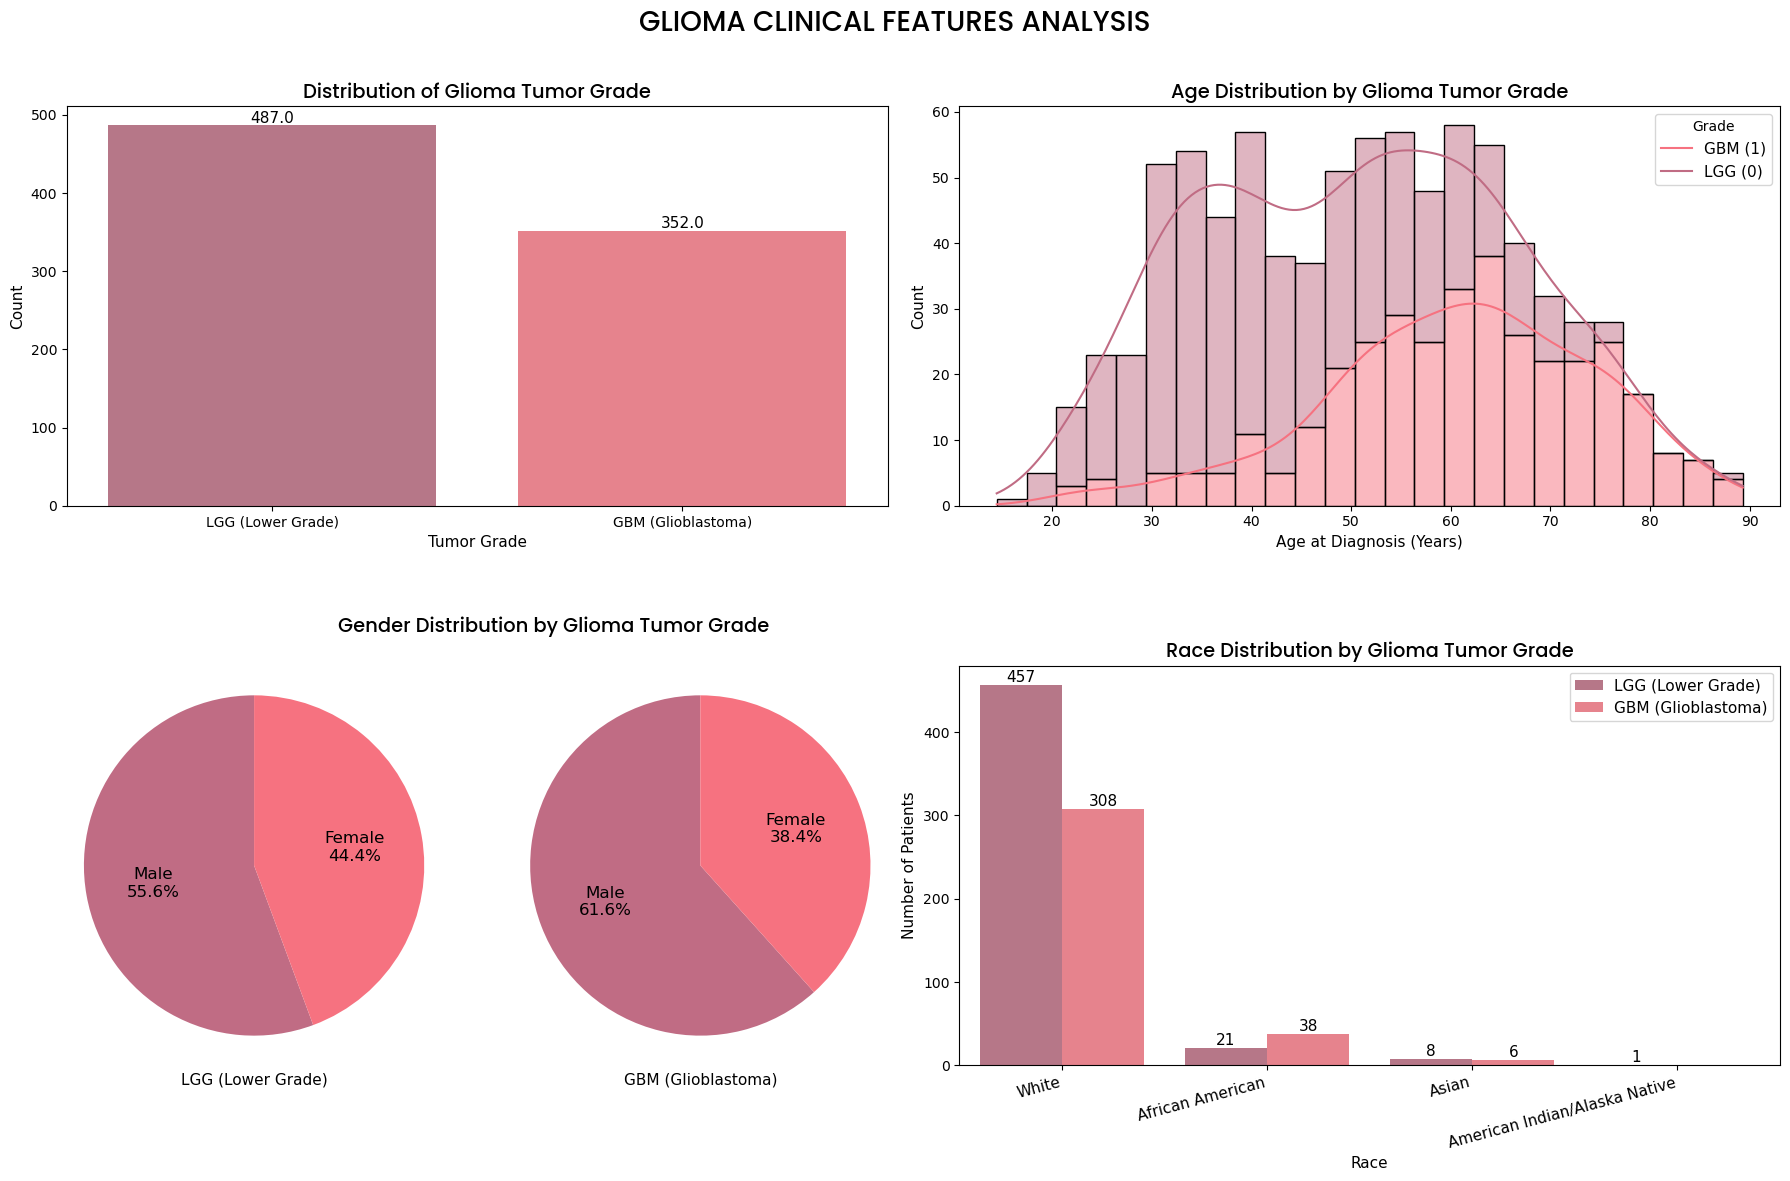

In [14]:
# 1. Create Figure
fig = plt.figure(figsize=(18, 12))
fig.suptitle('GLIOMA CLINICAL FEATURES ANALYSIS', fontsize=20, x=0.5, fontfamily='Poppins')

# 2. Plot 1 & 2
Target_Variable_Analysis()
Age_Distribution_by_grade()

# 3. Prepare axes for Gender (Plot 3)
Clinical_axes = [
    plt.subplot2grid((2, 4), (1, 0)),  # LGG Pie
    plt.subplot2grid((2, 4), (1, 1)),  # GBM Pie
    plt.subplot2grid((2, 4), (1, 2), colspan=2)  # Race Plot
]

# 4. Plot 3 — Gender
plot_gender_distribution(df, fig, Clinical_axes)

# 5. Plot 4 — Race
plot_race_distribution(df, Clinical_axes[2])

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(hspace=0.4, top=0.9)
plt.show()


## 3. Gene Mutation Features Analysis

### a. Frequency Mutaion Plot 
The frequency plot tells us which genes are common vs rare in the patient cohort.Helps focus analysis on genes that occur in a significant number of patients. Genes with high mutation frequency are more likely to be relevant features for classification (e.g., classifying LGG vs. GBM) or prediction (e.g., predicting patient survival).

In [15]:
def frequency_mutation():
# Calculate the mutation frequency for the top 10 most frequently mutated genes
    mutation_freq = df[MUTATION_FEATURES].sum().sort_values(ascending=False).head(10)

    sns.barplot(x=mutation_freq.values, y=mutation_freq.index, color='#C06C84')
    plt.title('Top 10 Most Frequent Gene Mutations (Total Patients)', fontsize=14, fontfamily='Poppins')
    plt.xlabel('Gene')
    plt.ylabel('Number of Mutated Patients')
    plt.xticks(rotation=45, ha='right')

Observations:
- This plot shows the top 10 genes with high mutation frequency out of the 20 genes. 
- The mutations in IDH1, TP53, and ATRX are the core molecular features of this cohort and are critical for classification and prognosis.
- PTEN, EGFR, and CIC, are found in between 100 and 150 patients. While important, they are half as frequent as ATRX and less than a third as frequent as IDH1.

### b. Top 10  Mutation Features for Glioma Grading by ANOVA F-value Scores 

- ANOVA F-score analysis is to perform univariate feature selection to identify genes that are the most powerful individual predictors of your target classes (LGG vs. GBM).
- To statistically quantify how well a single feature (gene mutation status) can discriminate between the two target classes (LGG and GBM).
- Higher F-score $\rightarrow$ Stronger statistical evidence that the gene's mutation status is significantly different between LGG and GBM, meaning it is highly discriminative.


In [16]:
 def ANNOVA_Fscores_Grading():
    try:
        selector = SelectKBest(score_func=f_classif, k='all')
        # Assuming 'X' and 'y' are defined and ready for fitting
        selector.fit(X, y)
    except NameError:
        print("Warning: X or y (target variable for selector) is not defined. Selector initialization skipped.")
        # If X or y aren't defined, the whole block will fail, but this prepares the 'selector' object if they are.

    # Assuming your clinical features are these two (adjust the list if you have more)
    clinical_features_to_exclude = ['Age_at_diagnosis', 'Gender', 'Race']
    # Visualizing Feature Importance/Scores (for the presentation)
    feature_scores = pd.Series(selector.scores_, index=X.columns).sort_values(ascending=False)

    # 2. Filter out the clinical features
    # Use the tilde (~) operator for negation and .isin() to find features NOT in the exclude list.
    mutation_only_scores = feature_scores[~feature_scores.index.isin(clinical_features_to_exclude)]

    # 3. Select the top 5 features from the filtered list (these will be the top 6 mutation features)
    top_10_mutation_features = mutation_only_scores.head(10)

    sns.barplot(
        x=top_10_mutation_features.values,   # The top 10 mutation names
        y=top_10_mutation_features.index,  # The corresponding F-scores
       color='#F67280'
    )
    plt.title(f'Top 10  Mutation Features for Glioma Grading by ANOVA F-value Scores', fontsize=14, fontfamily='Poppins')
    plt.xlabel('Features')
    plt.ylabel('F-Score')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')
    return top_10_mutation_features

Observations:
 - IDH1 is the overwhelmingly dominant and most discriminative feature, with an F-score exceeding 800.
 - PTEN is the second-ranked gene, but its F-score is only around 100, indicating a massive drop-off in predictive power after IDH1.

Discrepancy with Frequency Ranking
- A critical observation is the difference between this ANOVA F-score ranking and the initial Mutation Frequency ranking
     - Although TP53 was the second most frequent mutation (in 350 patients), it has one of the lowest F-scores in this plot (ranked 9th, F-score 30).
     - This suggests that the TP53 mutation occurs with a similar frequency in both LGG and GBM, making it a poor feature for discriminating between the two classes
- The ANOVA F-score analysis clearly shows that IDH1 is the most valuable feature for the  classification model (LGG vs. GBM).
- PTEN and ATRX providing the next most useful information.
- TP53 has the high-frequency but low-discriminative feature. Hence  TP53 may not contribute much to separating the two grades
- In the optimal Features slection, IDH1, PTEN and ATRX must be included. 

## C. GBM vs. LGG Mutation Distribution for the Top 10  highly discriminant Mutation Features based on Anova score 

This plot shows the proportion of patients with and without a mutation for the top-ranked discriminative genes based on the Anova f1 score across the two major Glioma grades: GBM (Glioblastoma) and LGG (Lower Grade).It shows the absolute count of mutations for each gene in the aggressive GBM group versus the less aggressive LGG group.It visually confirms why the genes ranked high in the ANOVA F-score. A gene with a high F-score should have a major imbalance in its bar heights between the two grades.

In [17]:
def Mutation_Profie_by_Grade(top_10_mutation_features):
    #----Top 10 higly dsicrimantive genes from ANNOVA f1 scores-----
    Top_mutation_cols=top_10_mutation_features.index
 
    # Assuming 'gbm' and 'lgg' are DataFrames defined previously:
    # gbm = df[df['Tumor_Grade']==1]
    # lgg = df[df['Tumor_Grade']==0]
    gbm = df[df['Tumor_Grade'] == 'GBM (Glioblastoma)'] 
    lgg = df[df['Tumor_Grade'] == 'LGG (Lower Grade)']
    # The sum() function counts the number of '1's (mutations) in the selected columns
    gbm_counts = gbm[Top_mutation_cols].sum()
    lgg_counts = lgg[Top_mutation_cols].sum()    
    # ----------------------------------------------------------------------
    # --- CLUSTERED PLOTTING CODE ---
    # ----------------------------------------------------------------------
    num_genes = len(Top_mutation_cols)
    bar_width = 0.35
  
    # Create an array of numerical positions for the x-axis groups
    x = np.arange(num_genes)

    # --- Plotting ---
    # 1. Plot LGG bars (right of center)
    plt.bar(
        x - bar_width/2, 
        lgg_counts.values, 
        bar_width, 
        alpha=0.8, 
        label="LGG (0)",
        color='#C06C84'
    )    

    # 2. Plot GBM bars (left of center)
    plt.bar(
        x + bar_width/2, 
        gbm_counts.values, 
        bar_width, 
        alpha=0.8, 
        label="GBM (1)",
        color='#F67280'
    )

    # --- Labeling and Formatting ---
    # Set the X-axis tick labels to the gene names, centered on the group
    plt.xticks(x, Top_mutation_cols, rotation=0, ha='center', fontsize=10) 

    plt.ylabel("Mutation Count", fontsize=12)
    plt.title("Mutation Profile by Grade for the Highly Discriminative Mutation Features", fontsize=14,fontfamily='Poppins' )
    plt.legend(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)


Observations:
This analysis confirms that the top 3 features (IDH1, PTEN, ATRX) are highly relevant for grading Glioma:

- The IDH1 gene is the most powerful molecular feature for separating the two clinical grades.IDH1 mutations are strongly associated with the LGG grade

- PTEN & EGFR mutations are associated with the GBM grade.These genes are significantly more common in the aggressive GBM group

- ATRX and CIC mutations are associated with the LGG grade.These two genes show less extreme separation than IDH1.
- The TP53 gene, despite its high frequency, shows relatively poor separation. Both LGG (0) and GBM1( )bars are high. 

## d. Comutaion Correlation Matrix for the Top 10  highly discriminant Mutation Features based on Anova score 

This Co-Mutation Correlation Matrix provides a detailed statistical map of the relationship between top  10 key gene mutations in the Glioma cohort. The values represent the Pearson correlation coefficient (r), where positive values indicate co-occurrence  and negative values indicate mutual exclusivity.

In [18]:
def comutaion_correlation(top_10_mutation_features):
    Top_mutation_cols=top_10_mutation_features.index
    corr = df[Top_mutation_cols].corr()

    # --- 3. Generate Heatmap with Annotations ---
    sns.heatmap(
        corr, 
        annot=True,              # <--- THIS IS THE KEY CHANGE
        cmap="flare", 
        center=0,
        fmt=".2f",               # Format the annotations to two decimal places
        linewidths=.5,           # Add lines for separation
        cbar_kws={'label': 'Pearson Correlation Coefficient (r)'}
    )
    plt.title("Co-Mutation Correlation Matrix ", fontsize=14,fontfamily='Poppins')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')

Observations: 
- IDH1 and ATRX (r = 0.45): A strong co-occurrence, confirming that the {IDH1-mutant / ATRX-mutant} profile is a primary defining feature of a LGG .
- ATRX and TP53 (r = 0.55): This is the highest co-occurrence in the matrix. These two mutations frequently occur together, often alongside IDH1.
- IDH1 and PTEN (r = -0.39): The strongest mutual exclusivity in the matrix. This means if a tumor has the favorable IDH1 mutation, it is highly unlikely to have the high-grade driver PTEN mutation, and vice-versa.
- IDH1 and EGFR (r = -0.36): A strong negative correlation. IDH1-mutant tumors(LGG) almost never show the {EGFR}  alterations common in aggressive {IDH-wildtype} GBM.
- TP53 shows strong synergy with the LGG markers (ATRX, r=0.55; IDH1, r=0.34).However, TP53 shows negligible correlation with key GBM drivers (PTEN, r=-0.07; EGFR, r=-0.17), indicating its mutation occurs relatively independent in the GBM-associated pathway, making it a poor single separator of the two grades.

## d. Dashboard Showing all the Gene Mutations Feature Analysis Plots

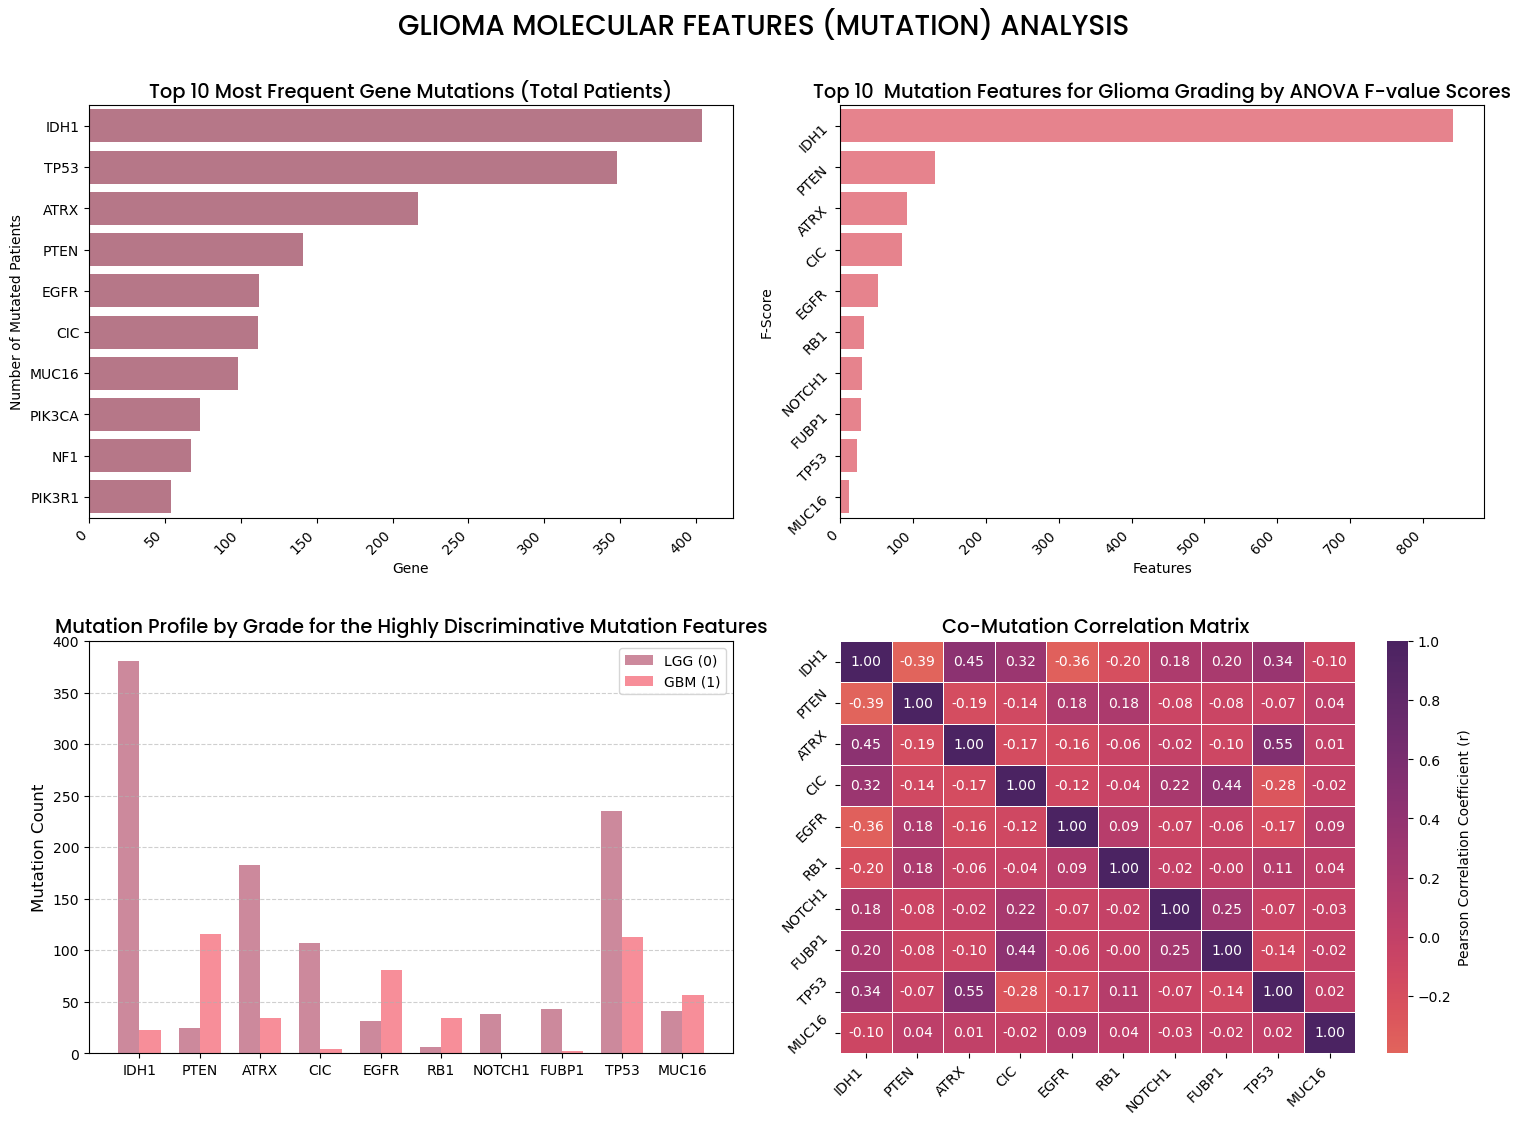

In [19]:
fig=plt.figure(figsize=(18, 12))
fig.suptitle('GLIOMA MOLECULAR FEATURES (MUTATION) ANALYSIS', fontsize=20,x=0.5, fontfamily='Poppins')
CUSTOM_COLORS = ['#C06C84', '#F67280']

COLOR_NOT_MUTATED = '#C06C84'
COLOR_MUTATED = '#F67280'
CUSTOM_COLOR_MAP = [COLOR_NOT_MUTATED, COLOR_MUTATED] # Order: [0, 1]

# ----------------------------
# Plot 1: TARGET VARIABLE ANALYSIS -
# ----------------------------
plt.subplot2grid((2, 4), (0, 0), colspan=2)
frequency_mutation()
# ----------------------------
# Plot 2: Top 10  Mutation Features for Glioma Grading by ANOVA F-value Scores
# ----------------------------
plt.subplot2grid((2, 4), (0, 2), colspan=2)
top_10_mutation_features= ANNOVA_Fscores_Grading()
# ----------------------------
# Plot 3: Analyze top 3 key mutations (IDH1, ATRX, PTEN) across tumor grades
# ----------------------------
plt.subplot2grid((2, 4), (1, 0), colspan=2)
Mutation_Profie_by_Grade(top_10_mutation_features)

#High_discriminant_Genes()
#plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplot2grid((2, 4), (1, 2), colspan=2)
comutaion_correlation(top_10_mutation_features)
    
fig.subplots_adjust(
    hspace=0.3,
    wspace=0.4,  #  Increase Hspace to create space between rows 
    top=0.9      #  Set a manual top margin to ensure the suptitle has room
)
plt.show()

# III. Glioma Optimal  Features Selection
Two-stage feature selection process were carried out

- Step 1: Uses Random Forest (RF) to rank all candidate features.

- Step 2 2: Uses K-Fold Cross-Validation (CV) with Logistic Regression to iteratively select the optimal subset size (k) based on the RF ranking, maximizing the F1-Score.

## 1. Data Preparation and Initial Split

###  a. Prepares the Target  
Converts the categorical target variable into a numeric binary format required for classification (0 and 1).

In [20]:
#-------------------------------------------------------------
# 1. Target Selection
#-------------------------------------------------------------
# 1.1. Encoding and Cleaning
    
TARGET   ='Tumor_Grade'
if 'Tumor_Grade' in df.columns and df['Tumor_Grade'].dtype == object:
    df[TARGET] = df['Tumor_Grade'].replace({'LGG (Lower Grade)': 0, 'GBM (Glioblastoma)': 1})
elif 'Tumor_Grade' in df.columns:
    df[TARGET] = df['Tumor_Grade']

### b.  Defines the Search Space
Establishes the full list of candidate features to be evaluated.

In [21]:
#-------------------------------------------------------------
# 2. List All Feature for Selection
#-------------------------------------------------------------
# Full list of available features (including the ones you focused on)
ALL_FEATURES = [
    'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1', 
    'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'SMARCA4','CSMD3', 'GRIN2A', 'IDH2', 
    'FAT4', 'PDGFRA', 'Gender', 'Race','Age_at_diagnosis'
]

###  c. Handles Missing Data
Creates a working dataframe (df_model) by dropping any rows with missing values in the target or any of the 23 features, ensuring clean inputs for the model.

In [22]:
# Select all features and target, then drop missing values
df_model = df[[TARGET] + ALL_FEATURES].dropna()

In [23]:
#-------------------------------------------------------------
# 3. Set X and y
#-------------------------------------------------------------
X = df_model[ALL_FEATURES]
y = df_model[TARGET]

###  d. Data Spilt 
Splits the data into a large training/validation set (80 %) and a small, pristine test set (20%). stratify=y ensures both sets maintain the same proportion of LGG/GBM cases.

In [24]:
#-------------------------------------------------------------
# --- 4. Split Data (Training/Validation Set and Final Test Set)
#-------------------------------------------------------------
# We split once to keep the final test set pristine for final evaluation.
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train Shape", X_train_val.shape)
print("Test Shape", X_test.shape)

Train Shape (671, 23)
Test Shape (168, 23)


## 2. Random Forest Feature Ranking 
A Random Forest model assigns an importance score to every feature (based on how much it reduces impurity).

- Intial Filtering: Uses Random Forest (RF) to rank all candidate features and select the top 15 features as a first optimal subset.
- Output: A ranked subset of the Top 15 Candidate Features.


In [25]:
def Random_Forest_Ranking():
#-------------------------------------------------------------
# --- 5. Feature Importance Ranking (using Random Forest on the Training/Validation set) ---
#-------------------------------------------------------------
# --Ranking features by importance...
    rf_ranker = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_ranker.fit(X_train_val, y_train_val)

    feature_importances = pd.Series(rf_ranker.feature_importances_, index=X_train_val.columns)

    # Sort features by importance in descending order
    feature_importances_sorted = feature_importances.sort_values(ascending=False)

    # Truncate the list to the Top 15
    MAX_K_CANDIDATES = 15
    ranked_features = feature_importances_sorted.index.tolist()
    # This list now select the the top 15 features for the next CV loop to test
    ranked_features_for_cv = ranked_features[:MAX_K_CANDIDATES] 

    # --- 5.1. RF Ranking FEATURE IMPORTANCE PLOT  ---
    top_importances = feature_importances_sorted.head(MAX_K_CANDIDATES)
    sns.barplot(
        x=top_importances.values, 
        y=top_importances.index, 
        color='#C06C84'
    )
    plt.title(f'Top {MAX_K_CANDIDATES} Initial Feature Ranking by Random Forest', fontsize=14,fontfamily='Poppins')
    plt.xlabel('RF Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    return ranked_features_for_cv, feature_importances

Observations:(Refer Dashboard)
- The top two features—Age_at_diagnosis (RF Score approx 0.32) and the IDH1 mutation status (RF Score approx 0.28)—account for nearly 60% of the total feature importance, dominating the ranking.
- A second tier of molecular markers shows moderate, distinct importance scores (between 0.04 and 0.06): ATRX, CIC, and PTEN.
- The clinical features (Race, Gender) and other molecular markers fall into the lower half of the ranking (all below 0.03 importance score

## 3. Optimal Subset Selection with Cross-Validation


We iteratively test k features (starting from k=1 up to k=15, based on the RF rank) using Logistic Regression within a 5-Fold Cross-Validation loop. The goal is to find the smallest feature set k) that maximizes the Macro F1-Score.

Output: The Optimal Feature Subset (the list of features that achieved the highest F1-Score).

In [26]:
def five_fold_CV(ranked_features_for_cv):
    f1_scorer = make_scorer(f1_score, average='macro')
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    best_score = -1
    optimal_subset = []
    results = []
    # Scale continuous features for Logistic Regression (only needed features will be scaled)
    scaler = StandardScaler()
    continuous_cols = ['Age_at_diagnosis'] # Assuming 'Age_at_diagnosis' is back in ALL_FEATURES for full context

    # The loop now only runs up to the length of the Top fetaures selected by RF Ranking
    for k in range(1, len(ranked_features_for_cv) + 1): 
        current_features = ranked_features_for_cv[:k]

        X_k = X_train_val[current_features]

        # Scale continuous columns within the current subset
        features_to_scale = [f for f in current_features if f in continuous_cols]

        if features_to_scale:
            X_k = X_k.copy()
            X_k[features_to_scale] = scaler.fit_transform(X_k[features_to_scale])

        model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

        cv_scores = cross_val_score(model, X_k, y_train_val, cv=kf, scoring=f1_scorer)
        mean_score = cv_scores.mean()

        results.append({'k': k, 'features': current_features, 'score': mean_score})

        if mean_score > best_score:
            best_score = mean_score
            optimal_subset = current_features

    # --- 6.1. CROSS-VALIDATION PLOT ---
    results_df = pd.DataFrame(results)
    best_k = len(optimal_subset)
  
    sns.lineplot(x='k', y='score', data=results_df, marker='o', color=CUSTOM_COLORS[0], linewidth=2)

    # Highlight the optimal point (the peak score)
    plt.plot(best_k, best_score, 'o', color=CUSTOM_COLORS[1], markersize=10, 
             label=f'Optimal Subset Size: {best_k}')

    plt.title(f'Optimal Subset Selection: CV F1-Score', fontsize=14, fontfamily='Poppins')
    plt.xlabel('Number of Features (k)')
    plt.ylabel('5-Fold Cross-Validation F1-Score (Macro)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    return optimal_subset, best_k

Observations:(Refer Dashboard)

- The model performance (F1-Score) jumped steeply with the first few features, proving that the top-ranked genes (IDH1, ATRX) and Age-at-Diagnosis account for the majority of the predictive power.
- The highest CV F1-Score (approx 0.93) was achieved with 8 features. This is the optimal, most parsimonious (minimal) feature subset.
- Adding any of the remaining 7 features (k > 8) provided no significant performance improvement, indicating they are redundant for the classification task.
- The final, recommended feature set for the high-performing model consists of 8 features.

In [27]:
def Optimalsubset_Plot(feature_importances,optimal_subset,best_k):
    optimal_subset_importances = feature_importances[optimal_subset].sort_values(ascending=False)

    sns.barplot(
        x=optimal_subset_importances.values, 
        y=optimal_subset_importances.index, 
        color=CUSTOM_COLORS[1]
    )
    plt.title(f'Optimal Feature Subset (N={best_k})', fontsize=14, fontfamily='Poppins')
    plt.xlabel('RF Importance Score')
    plt.ylabel('Selected Features')
    plt.grid(axis='x', linestyle='--', alpha=0.6)

## 4. Correlation Analysis and Verification

A Correlation Matrix (heatmap)  using the final optimal subset and the target variable. This step visually verifies the linear relationship between the selected features and the outcome (Tumor Grade), and checks for high multicollinearity among the selected features.

In [28]:
def Correltaion_Optimalsubset():
    # Prepare Data and Calculate Correlation for the Optimal Subset + Target
    all_cols_numeric = [TARGET] + optimal_subset
    df_corr = df[all_cols_numeric].dropna().copy()
    correlation_matrix = df_corr.corr()

    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='flare', 
        fmt=".2f",
        linewidths=0.5,
        linecolor='black'
    )
    plt.title(f'Correlation Matrix (Optimal N={best_k})', fontsize=14, fontfamily='Poppins')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')

Observations:(Refer Dashboard)
    
- Primary Predictors (Correlation with Tumor_Grade):

    - IDH1 (r = -0.71): The strongest individual predictor. Its presence is strongly linked to Lower Grade Glioma (LGG).

    - Age_at_diagnosis (r = 0.53): The strongest positive predictor. Higher age is strongly linked to Glioblastoma (GBM).

    - ATRX & PTEN: Moderate, distinct predictive contributions.

- Low Multicollinearity: The highest inter-feature correlation is 0.45 (between IDH1 and ATRX), which is well below the problem threshold (|r| > 0.8).

- The final feature set is stable and provides highly distinct information to the classifier.

##  5.  Dashboard for  Gliomo Optimal Features Selection

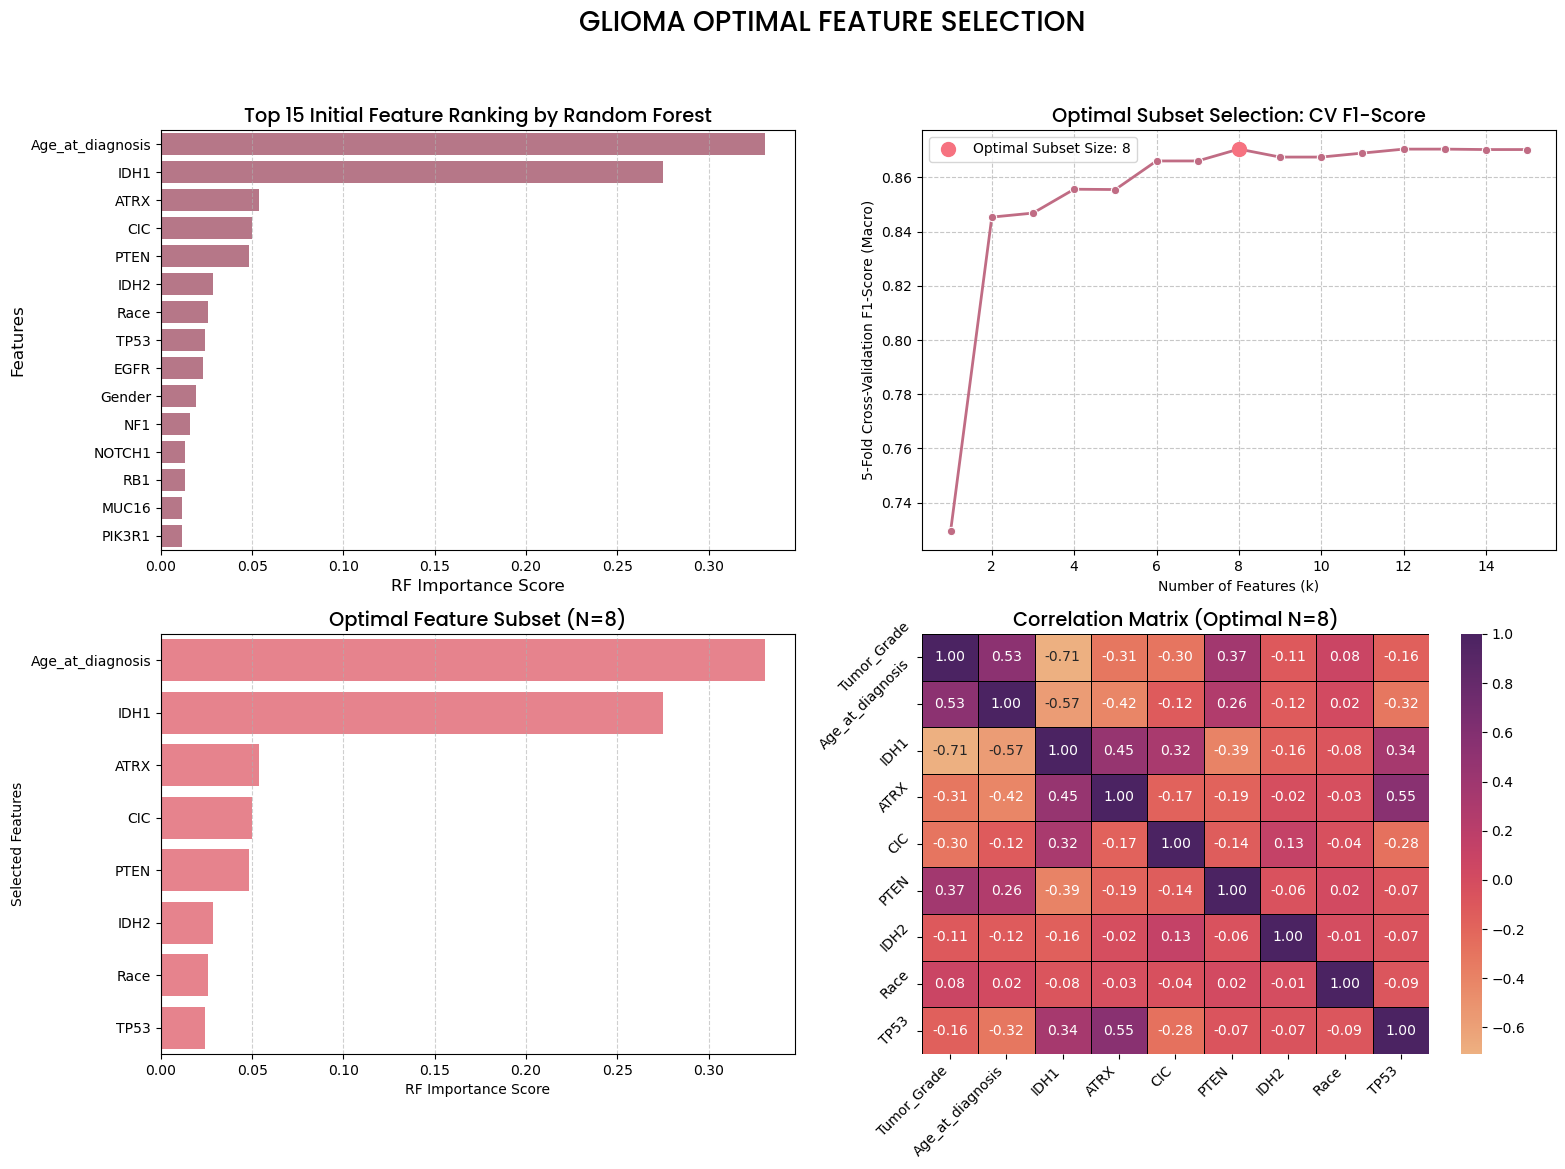

In [29]:
fig=plt.figure(figsize=(18, 12), dpi=100)
fig.suptitle('GLIOMA OPTIMAL FEATURE SELECTION ', fontsize=20,x=0.5, fontfamily='Poppins')
CUSTOM_COLORS = ['#C06C84', '#F67280']
#-------------------------------------------------------------
# --- 5. Feature Importance Ranking (using Random Forest on the Training/Validation set) ---
#-------------------------------------------------------------
plt.subplot2grid((2, 2), (0, 0))
ranked_features_for_cv, feature_importances=Random_Forest_Ranking()
#-------------------------------------------------------------
# --- 6. Iterative Feature Selection with Cross-Validation 
#-----Uses only the intial filtered top features form RF Ranking---
# ----Use F1-Score (macro) as the optimization metric, balancing Precision and Recall for both classes.
#-------------------------------------------------------------
plt.subplot2grid((2, 2), (0, 1)) # Position 2: Top Right
optimal_subset, best_k=five_fold_CV(ranked_features_for_cv)
# --- 6.2 . Optimal Feature Subset Plot ---
plt.subplot2grid((2, 2), (1, 0)) # Position 3: Bottom Left
Optimalsubset_Plot(feature_importances,optimal_subset,best_k)
#-------------------------------------------------------------
# # --- 7 Correlation Matrix as a Heatmap ---
#-------------------------------------------------------------
plt.subplot2grid((2, 2), (1, 1)) # Position 4: Bottom Right
Correltaion_Optimalsubset()

plt.show()

# IV. Glioma Classification and Prediction

## 1. Assigning the train and test data  using optimal subset

In [30]:
#-------------------------------------------------------------
# --- 8 Training the model and Prediction on the Test Data (using Optimal Subset) ---
#-------------------------------------------------------------
# Final Training Data (only optimal features)
X_final_train = X_train_val[optimal_subset]
y_final_train = y_train_val
print("Train Shape", X_final_train.shape)

Train Shape (671, 8)


In [31]:
# Final Test Data (only optimal features)
X_final_test = X_test[optimal_subset]
y_final_test = y_test
print("Test Shape", X_final_test.shape)

Test Shape (168, 8)


In [32]:
# Re-scale continuous features in the optimal set
 # Scale continuous features for Logistic Regression (only needed features will be scaled)
scaler = StandardScaler()
continuous_cols = ['Age_at_diagnosis'] # Assuming 'Age_at_diagnosis' is back in ALL_FEATURES for full context

final_features_to_scale = [f for f in optimal_subset if f in continuous_cols]

if final_features_to_scale:     
    X_final_train = X_final_train.copy()
    X_final_test = X_final_test.copy()
    
    X_final_train[final_features_to_scale] = scaler.fit_transform(X_final_train[final_features_to_scale])
    X_final_test[final_features_to_scale] = scaler.transform(X_final_test[final_features_to_scale])

In [33]:
# --- Metrics Storage for the bar plot---
model_names = []
f1_scores = []
accuracies = []
#----------------

## 2.  Logistic Regression Classifier Model

In [34]:
#-----------------------------------------------------------------
#-------------------Logistic Regression--------------------------------------------
#-----------------------------------------------------------------------------------
# Train final model
Log_model = LogisticRegression(solver='liblinear',random_state=42, class_weight='balanced')
Log_model.fit(X_final_train, y_final_train)

log_y_pred_final = Log_model.predict(X_final_test)

# Calculate and store metrics
log_f1 = f1_score(y_final_test, log_y_pred_final, average='weighted')
log_final_acc = Log_model.score(X_final_test, y_final_test)
model_names.append("Logistic Regression")
f1_scores.append(log_f1)
accuracies.append(log_final_acc)

# --- Logistic Regression- Confusion Matrix visualization on Test Data ---
log_cm_final = confusion_matrix(y_final_test, log_y_pred_final)  


## 3.  SVC Classifier Model

In [35]:
#----------------------------------------------------------------------------
#-------------------SVM Classifier-------------------------------------------
#----------------------------------------------------------------------------
# Train final model
svc_model = SVC(random_state=42)
svc_model.fit(X_final_train, y_final_train)

svc_y_pred_final = svc_model.predict(X_final_test)

# Calculate and store metrics
svc_f1 = f1_score(y_final_test, svc_y_pred_final, average='weighted')
svc_final_acc = svc_model.score(X_final_test, y_final_test)
model_names.append("SVC")
f1_scores.append(svc_f1)
accuracies.append(svc_final_acc)

# ------------SVC Confusion Matrix visualization ---------------------
svc_cm_final = confusion_matrix(y_final_test, svc_y_pred_final)

## 4.  Random Forest Classifier Model

In [36]:
#----------------------------------------------------------------------------
#-------------------Random Forest Classifier-------------------------------------------
#----------------------------------------------------------------------------
# Train final model
random_model = RandomForestClassifier(random_state=42)
random_model.fit(X_final_train, y_final_train)

random_y_pred_final = random_model.predict(X_final_test)

# Calculate and store metrics
random_f1 = f1_score(y_final_test, random_y_pred_final, average='weighted')
random_final_acc = random_model.score(X_final_test, y_final_test)
model_names.append("Random Forest")
f1_scores.append(random_f1)
accuracies.append(random_final_acc)

# ------------Random Forest Confusion Matrix visualization ---------------------
random_cm_final = confusion_matrix(y_final_test, random_y_pred_final)

## 5.  Dashborad Showing the Classifier Confusion matrix and Comparison

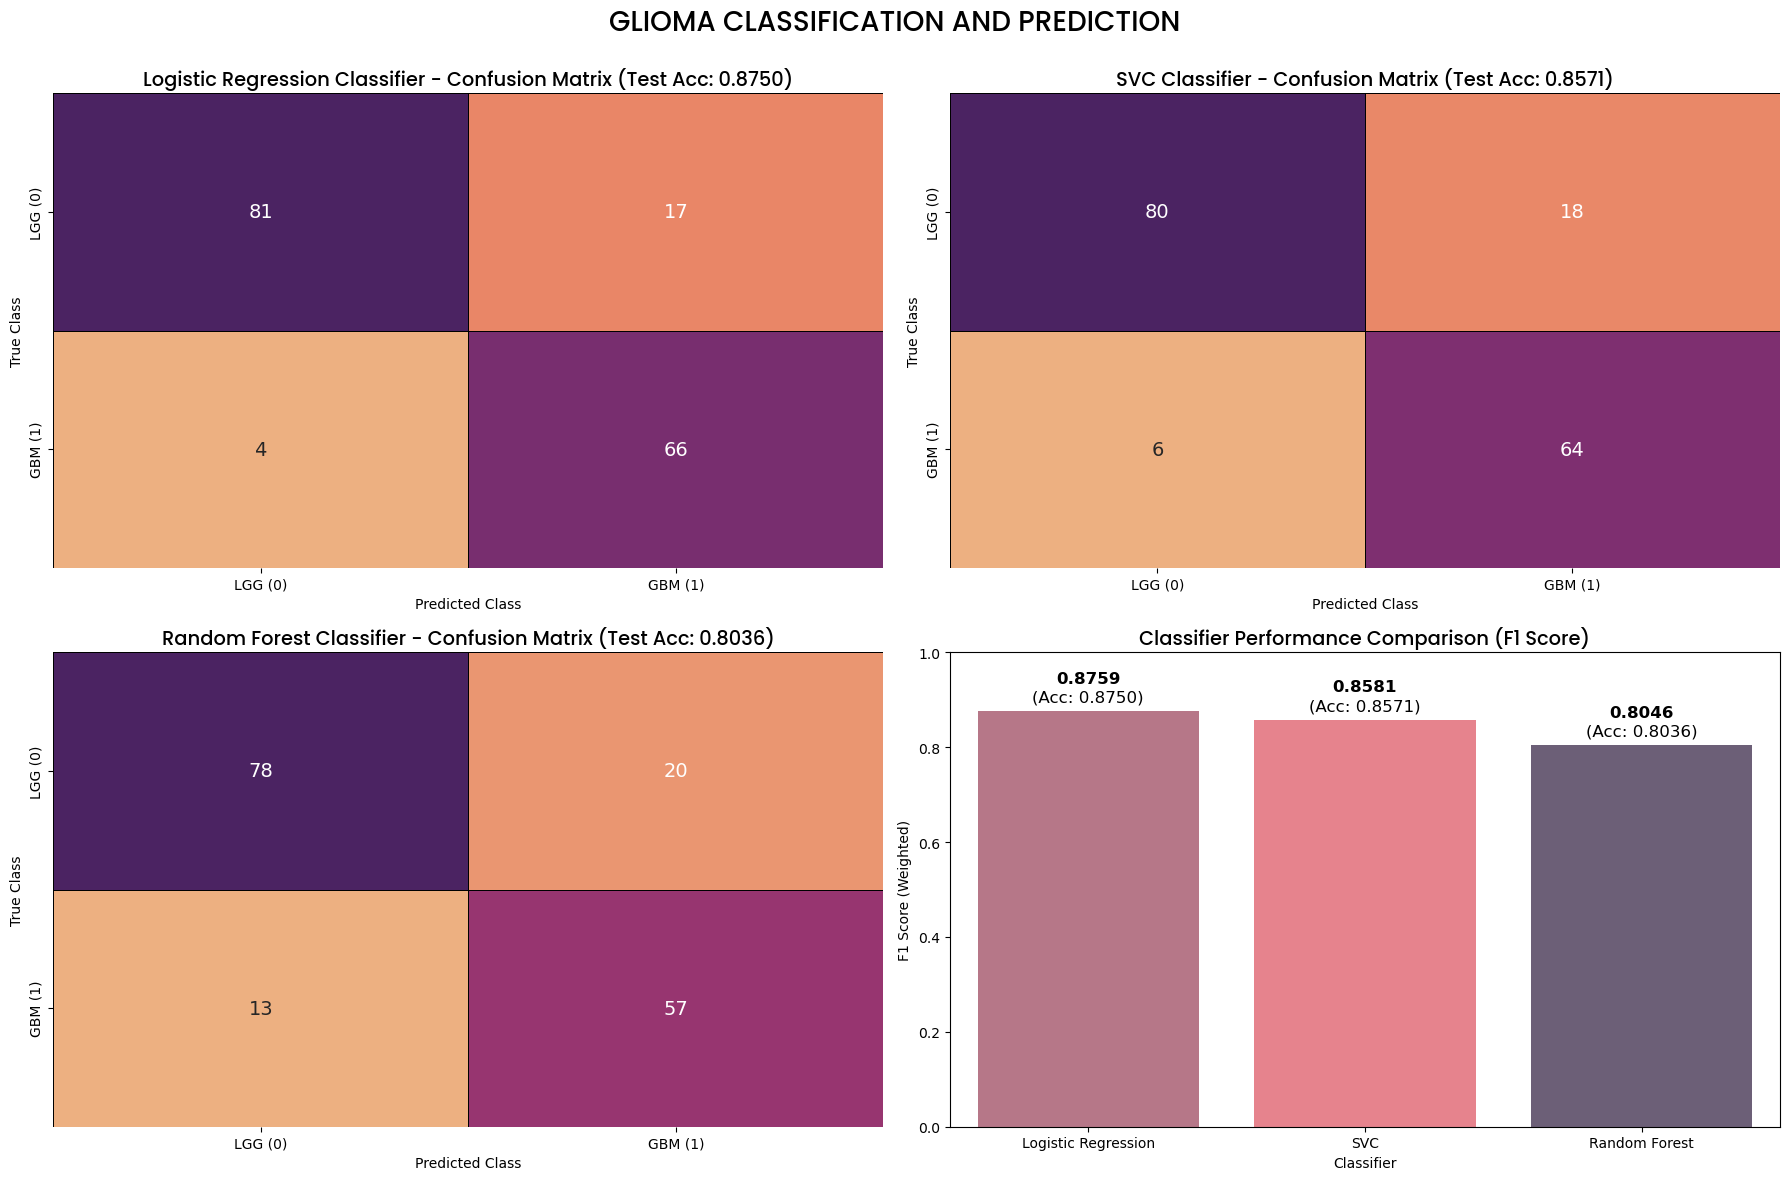

In [37]:
fig=plt.figure(figsize=(18, 12), dpi=100)
fig.suptitle('GLIOMA CLASSIFICATION AND PREDICTION', fontsize=20,x=0.5, fontfamily='Poppins')
CUSTOM_COLORS = ['#C06C84', '#F67280']
#---------------------------------------------------------------------------------
#-------------------Logistic Regression--------------------------------------------
#-----------------------------------------------------------------------------------

plt.subplot2grid((2, 2), (0, 0)) # Position 1: Top Left
sns.heatmap(
        log_cm_final,
        annot=True,
        fmt='d', 
        cmap='flare',
        linewidths=0.5,
        linecolor='black',
        cbar=False,
        xticklabels=['LGG (0)', 'GBM (1)'],
        yticklabels=['LGG (0)', 'GBM (1)'],
        annot_kws={"fontsize": 14} 
    )
plt.title(f'Logistic Regression Classifier - Confusion Matrix (Test Acc: {log_final_acc:.4f})',fontsize=14,fontfamily='Poppins')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

#----------------------------------------------------------------------------
#-------------------SVM Classifier-------------------------------------------
#----------------------------------------------------------------------------

plt.subplot2grid((2, 2), (0, 1)) # Position 2: Top Right

sns.heatmap(
    svc_cm_final,
    annot=True,
    fmt='d', 
    cmap='flare',
    linewidths=0.5,
    linecolor='black',
    cbar=False,
    xticklabels=['LGG (0)', 'GBM (1)'],
    yticklabels=['LGG (0)', 'GBM (1)'],
    annot_kws={"fontsize": 14} 
)
plt.title(f'SVC Classifier - Confusion Matrix (Test Acc: {svc_final_acc:.4f})',fontsize=14,fontfamily='Poppins')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

#----------------------------------------------------------------------------
#-------------------Random Forest Classifier-------------------------------------------
#----------------------------------------------------------------------------
plt.subplot2grid((2, 2), (1, 0)) # Position 3: Bottom Left

sns.heatmap(
    random_cm_final,
    annot=True,
    fmt='d', 
    cmap='flare',
    linewidths=0.5,
    linecolor='black',
    cbar=False,  
    xticklabels=['LGG (0)', 'GBM (1)'],
    yticklabels=['LGG (0)', 'GBM (1)'],
    annot_kws={"fontsize": 14} 
)
plt.title(f'Random Forest Classifier - Confusion Matrix (Test Acc: {random_final_acc:.4f})',fontsize=14,fontfamily='Poppins')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

#----------------------------------------------------------------------------
#-------------------Model Comparison Bar Chart-------------------------------
#----------------------------------------------------------------------------

plt.subplot2grid((2, 2), (1, 1)) # Position 4: Bottom Right

metrics_df = pd.DataFrame({
    'Model': model_names,
    'F1 Score (Weighted)': f1_scores,
    'Accuracy': accuracies
})

# Use F1 Score for comparison chart
sns.barplot(
    x='Model', 
    y='F1 Score (Weighted)', 
    data=metrics_df, 
    palette=['#C06C84', '#F67280', '#6C5B7B']
)

# Add text labels on top of the bars
for index, row in metrics_df.iterrows():
    plt.text(
        index, 
        row['F1 Score (Weighted)'] + 0.06, # Position slightly below the top of the bar
        f'{row["F1 Score (Weighted)"]:.4f}', 
        color='Black', 
        ha="center", 
        fontsize=12, 
        fontweight='bold'
    )
    # Add Accuracy label below F1
    plt.text(
        index, 
        row['F1 Score (Weighted)'] + 0.02,
        f'(Acc: {row["Accuracy"]:.4f})',
        color='Black',
        ha="center",
        fontsize=12
    )


plt.ylim(0, 1.0)
plt.title('Classifier Performance Comparison (F1 Score)', fontsize=14, fontfamily='Poppins')
plt.ylabel('F1 Score (Weighted)')
plt.xlabel('Classifier')
plt.xticks(rotation=0)


plt.tight_layout(rect=[0, 0, 1, 0.98])

plt.show()

## 6.  Classifier Model Metrics Report

In [38]:
print("\n" + "="*70)
print("LOGISTIC REGRESSION CLASSIFICATION REPORT ON TEST DATA")
print(f"Optimal Feature Subset Size: {len(optimal_subset)}")
print(f"Final Test Accuracy: {Log_model.score(X_final_test, y_final_test):.4f}")
print("="*70)
print(classification_report(y_final_test, log_y_pred_final, target_names=['LGG (0)', 'GBM (1)']))

print("\n" + "="*70)
print("SVC CLASSIFICATION REPORT ON TEST DATA")
print(f"Optimal Feature Subset Size: {len(optimal_subset)}")
print(f"Final Test Accuracy: {svc_model.score(X_final_test, y_final_test):.4f}")
print("="*70)
print(classification_report(y_final_test, svc_y_pred_final, target_names=['LGG (0)', 'GBM (1)']))

print("\n" + "="*70)
print("Radom Forest CLASSIFICATION REPORT ON TEST DATA")
print(f"Optimal Feature Subset Size: {len(optimal_subset)}")
print(f"Final Test Accuracy: {random_model.score(X_final_test, y_final_test):.4f}")
print("="*70)
print(classification_report(y_final_test, random_y_pred_final, target_names=['LGG (0)', 'GBM (1)']))


LOGISTIC REGRESSION CLASSIFICATION REPORT ON TEST DATA
Optimal Feature Subset Size: 8
Final Test Accuracy: 0.8750
              precision    recall  f1-score   support

     LGG (0)       0.95      0.83      0.89        98
     GBM (1)       0.80      0.94      0.86        70

    accuracy                           0.88       168
   macro avg       0.87      0.88      0.87       168
weighted avg       0.89      0.88      0.88       168


SVC CLASSIFICATION REPORT ON TEST DATA
Optimal Feature Subset Size: 8
Final Test Accuracy: 0.8571
              precision    recall  f1-score   support

     LGG (0)       0.93      0.82      0.87        98
     GBM (1)       0.78      0.91      0.84        70

    accuracy                           0.86       168
   macro avg       0.86      0.87      0.86       168
weighted avg       0.87      0.86      0.86       168


Radom Forest CLASSIFICATION REPORT ON TEST DATA
Optimal Feature Subset Size: 8
Final Test Accuracy: 0.8036
              precision 

Observations: 

Accuracy F1 Score:
- The Logistic Regression Classifier is the best model, achieving the highest Test Accuracy (0.8750) and the highest Weighted F1 Score (0.8759).

- The Random Forest Classifier is the weakest model, with the lowest accuracy (0.8036) and F1 score (0.8046). 

Prediction Quality:
- The Logistic Regression Classifier model shows excellent performance, particularly in minimizing False Negatives (4). This means it is very good at identifying the severe class, GBM (1), when it is truly present. -It has a slightly higher number of False Positives (17), meaning it sometimes incorrectly labels an LGG case as GBM.
- The SVC model is very similar to Logistic Regression but performs slightly worse. It has 2 more False Negatives (6) and 1 more False Positive (18) than Logistic Regression.
- Random Forest  model is significantly worse at classifying the GBM (1) class. It has a high number of False Negatives (13), meaning it often fails to detect the severe GBM class, incorrectly classifying it as the less severe LGG class. It also has the highest number of False Positives (20).

The Logistic Regression Classifier is the most effective model for this classification task.

# V Predictions for a New Patients using Logistic Regression Classifier  and Mock dataset  

In [39]:
# 7. MAKE PREDICTIONS FOR A NEW PATIENT
# ==============================================================================
# --- ASSIGN BEST MODEL FOR PREDICTION FUNCTION ---
# Based on the user's statement, Log_model is the best classifier.
final_model = Log_model

def predict_new_patient(patient_data: dict, model, optimal_features: list, scaler: StandardScaler, continuous_cols: list):
      
    # 1. Create a DataFrame from the patient data, ensuring the order matches the model's training order
    input_df = pd.DataFrame([patient_data])
    X_new = input_df[optimal_features]

    # 2. Apply Scaling (MANDATORY if continuous features are present in the optimal set)
    X_scaled = X_new.copy()
    features_to_scale = [f for f in optimal_features if f in continuous_cols]
    
    if features_to_scale:
        # NOTE: We use transform(), NOT fit_transform(), as the scaler is already fitted on training data.
        X_scaled[features_to_scale] = scaler.transform(X_scaled[features_to_scale])

    # 3. Prediction
    # Use predict() for the final class label (0 or 1)
    prediction = model.predict(X_scaled)[0]
    
    # Use predict_proba() for the confidence score (probability of belonging to class 1, GBM)
    proba_gbm = model.predict_proba(X_scaled)[0][1]

    # 4. Format Output
    grade_label = "GBM (1)" if prediction == 1 else "LGG (0)"
    
    return grade_label, proba_gbm

# --- DEMONSTRATION OF NEW PREDICTION ---

# Simulate data for a new patient (Note: features must match the ALL_FEATURES list in the input dictionary)
# Example 1: Patient likely to be LGG (IDH1 mutation, young age)
new_patient_data_lgg = {
    'IDH1': 1, 'TP53': 0, 'ATRX': 1, 'PTEN': 0, 'EGFR': 0, 'CIC': 0, 
    'MUC16': 0, 'PIK3CA': 0, 'NF1': 0, 'PIK3R1': 0, 'FUBP1': 0, 'RB1': 0, 
    'NOTCH1': 0, 'BCOR': 0, 'SMARCA4': 0, 'GRIN2A': 0, 'IDH2': 0, 
    'FAT4': 0, 'PDGFRA': 0, 'Gender': 0, 'Race': 0, 
    'Age_at_diagnosis': 35.0 
}

# Example 2: Patient likely to be GBM (IDH1 wild-type, older age, EGFR mutation)
new_patient_data_gbm = {
    'IDH1': 0, 'TP53': 1, 'ATRX': 0, 'PTEN': 1, 'EGFR': 1, 'CIC': 0, 
    'MUC16': 0, 'PIK3CA': 0, 'NF1': 0, 'PIK3R1': 0, 'FUBP1': 0, 'RB1': 0, 
    'NOTCH1': 0, 'BCOR': 0, 'SMARCA4': 0, 'GRIN2A': 0, 'IDH2': 0, 
    'FAT4': 0, 'PDGFRA': 0, 'Gender': 1, 'Race': 0, 
    'Age_at_diagnosis': 70.0 
}

print("\n" + "="*70)
print("DEMONSTRATING PREDICTION ON NEW PATIENT DATA")
print("="*70)

# Predict for LGG-like patient
label_lgg, proba_lgg = predict_new_patient(new_patient_data_lgg, final_model, optimal_subset, scaler, continuous_cols)
print(f"Patient 1 (LGG-like features) Predicted Grade: {label_lgg} (GBM Probability: {proba_lgg:.4f})")

# Predict for GBM-like patient
label_gbm, proba_gbm = predict_new_patient(new_patient_data_gbm, final_model, optimal_subset, scaler, continuous_cols)
print(f"Patient 2 (GBM-like features) Predicted Grade: {label_gbm} (GBM Probability: {proba_gbm:.4f})")


DEMONSTRATING PREDICTION ON NEW PATIENT DATA
Patient 1 (LGG-like features) Predicted Grade: LGG (0) (GBM Probability: 0.0302)
Patient 2 (GBM-like features) Predicted Grade: GBM (1) (GBM Probability: 0.9674)
